<a href="https://colab.research.google.com/github/carloshernangarrido/kalmanfilters/blob/main/kalman_filter_const_slope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman filter for smoothing displacements designed by assuming a constant slope model

# Packages and modules

In [ ]:
# Packages installation
!pip install filterpy

In [ ]:
# Modules import
from filterpy.kalman import KalmanFilter # based on the book Kalman_and_Bayesian_Filters_in_Python.pdf
import numpy as np
import h5py
# import matlab.engine
import scipy.io
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import os



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Input parameters

## Classes

In [ ]:
class InputParameters: 
  '''
  Description
  ----------
  An object of Input Parameters for a Kalman Filter.

  Parameters
  ----------
  dim_x : int
    State vector dimension. The default state vector 
    dimension is 2, i.e. x_1 = position and x_2 = slope.
  dim_z : int
    Meassurement vector dimension. The default meassurement 
    vector dimension is 1, i.e. z = position.
  x_init : ndarray(dim_x, 1)
    Initial state
  dx : float
    Step size (Delta t)
  F : ndarray(dim_x, dim_x)
    State transition matrix. By default, it assumes constant slope and that 
    the next position is the current position plus current slope times dx
  H : ndarray(dim_z, dim_x)
    Meassurement function. By default, it assumes that only the position is 
    meassured.
  P : ndarray(dim_x, dim_x)
    Covariance matrix describing the uncertainty in the state vector due to 
    disturbances that excite the system. By default it is assumed that position 
    cannot change suddenly but velocity can change during a time step with a 
    variance of 100 (std = 10).
  R : ndarray(dim_z, dim_z)
    Covariance matrix describing the measurement noise. If only position is 
    meassured, it can be set as a scalar. By default, it assumes a variance of \
    1 for the noise in the position meassurement (std = 1).
  Q : ndarray(dim_x, dim_x)
    Variance matrix describing the process noise.
  
  Returns
  ----------
  object
    The Input Parameters for a Kalman Filter.  
  '''
    
  def __init__(self, dim_x=2, dim_z=1, x_init=np.array([[0.], [0.]]),\
               dx=.1, F=None, H=np.array([[1., 0.]]), \
               P=None, R=np.array([[1]]),
               Q=None, Q_process_noise_var=None):
    self.dim_x = dim_x
    self.dim_z = dim_z
    if x_init.shape == (dim_x,1):
      self.x_init = x_init
    else:
      raise Exception("Initial state must have the same dimension as the state")
    self.dx = dx
    if F is None:
      if dx is not None:
        self.F = np.array([[1., self.dx], 
                           [0., 1.]]) 
      else:
        raise Exception("If State transition matrix F is not defined, step size\
dx must be defined.")
    else:
      self.F = F
    self.H = H
    self.R = R
    if P is not None:
      self.P = P
    else:
      self.P = 1000*np.array([[R[0,0], 0.], 
                              [0., R[0,0]/(dx**2)]])
    if Q is None:
      if Q_process_noise_var is None:
        raise Exception("If process noise covariance matrix is not defined, \
process noise variance Q_process_noise_var must be defined.")
      from filterpy.common import Q_discrete_white_noise
      self.Q = Q_discrete_white_noise(dim=dim_x, dt=dx, var=Q_process_noise_var)
    else:
      self.Q = Q


class Modal:
  '''
  Description
  ----------
  An object of mode shape.

  Parameters
  ----------
  S : dict
    dictionary returned by scipy.io.loadmat(input_file_name)
    
  Returns
  ----------
  object
    The mode shape.  
  '''  
  def __init__(self, S):
      self.freq = np.array(S['modal']['freq'][0], dtype=np.float64)
      self.x = np.array(S['modal']['x'][0][0], dtype=np.float64)
      self.mode = np.array(S['modal']['mode'][0][0], dtype=np.float64)

## Load input file

In [ ]:
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field structural'

input_file_name = os.path.join(path, '13_10_11_run1_modal.mat')

S = scipy.io.loadmat(input_file_name)
modal = Modal(S)


In [ ]:
pos_init   = modal.mode[0]
slope_init = (modal.mode[-1]-modal.mode[0])/ \
             (len(modal.x)*np.mean(np.diff(modal.x, axis=0)))
ip = InputParameters(dx=np.mean(np.diff(modal.x, axis=0)), 
                     R=np.array([[(.01)**2]]),
                    #  Q_process_noise_var=(.01)**2,
                     Q=np.array([[0, 0], [0, (1e-4)**2]]),
                     x_init=np.array([pos_init, slope_init]).reshape(2,1))


# Process

## Filter definition

In [ ]:
# First, construct the object with the required dimensionality.
f = KalmanFilter(dim_x=ip.dim_x, dim_z=ip.dim_z)

# Set initial state
f.x = ip.x_init

# Define the state transition matrix
f.F = ip.F 

# Define the measurement function
f.H = ip.H

# Define the covariance matrix that describes the disturbance in the state
f.P = ip.P

# Define the covariance matrix that describes the noise in meassurement 
f.R = ip.R

# Assign the process noise.
f.Q = ip.Q

print(f)

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [[ 1.00000000e+00 -7.60318548e-04]].T
P = [[0.1     0.     ]
     [0.      0.00025]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[ 1. 20.]
     [ 0.  1.]]
Q = [[0.e+00 0.e+00]
     [0.e+00 1.e-08]]
R = [[0.0001]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f0d711ba050>


## Filter running

In [ ]:
n_steps = len(modal.x)

X_vector = modal.x.T
# n_vector = np.random.normal(0,10,n_steps)
z_vector = modal.mode.T
x_vector = np.zeros((ip.dim_x,n_steps))

f.x = ip.x_init
i = 0
while i<n_steps:
  # print(f'i = {i}\n\r---------------------\n\r{f.P}\n\r\n\r')    
  z = z_vector[0,i]
  f.predict()
  f.update(z=z)
  x_vector[0,i] = f.x[0]
  x_vector[1,i] = f.x[1]
  i += 1


# Plots

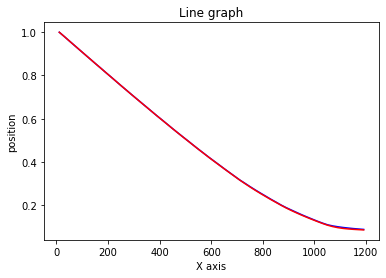

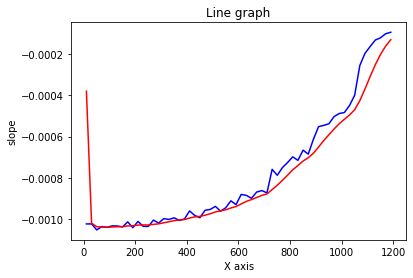

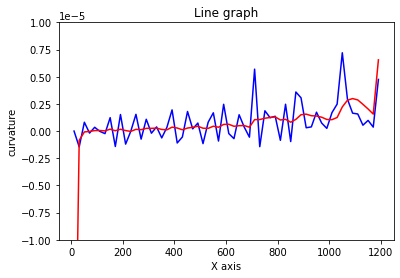

In [ ]:
# data to be plotted
plt.figure()
plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("position")
plt.plot(X_vector.T, z_vector.T, color ="blue")
plt.plot(X_vector.T, x_vector[0,].T, color ="red")
plt.show()

plt.figure()
plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("slope")
s_vector = np.diff(z_vector, prepend=0, axis=1)/ip.dx
s_vector[0,0] = s_vector[0,1]
s_vector_filt = x_vector[1,:]
plt.plot(X_vector.T, s_vector.T, color ="blue")
plt.plot(X_vector.T, s_vector_filt.T, color ="red")
plt.show()

plt.figure()
plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("curvature")
c_vector = np.diff(s_vector, append=0, axis=1)/ip.dx
c_vector_filt = np.diff(s_vector_filt, append=0, axis=0)/ip.dx
plt.plot(X_vector.T, c_vector.T, color ="blue")
plt.plot(X_vector.T, c_vector_filt.T, color ="red")
plt.ylim(-10e-6, 10e-6)
plt.show()  